# Convolutional Neural Network

In [111]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.utils import data

def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Zunächst laden wir wieder die Trainingsdaten ein und konvertieren Sie zu einem Tensor. Insgesamt sind es 60,000 Bilder und 784 Pixel + eine Spalte für die Labels der Bilder. 

In [199]:
train_data = np.genfromtxt('../data/mnist/mnist_train.csv', delimiter=',', skip_header =False)

train_x = torch.tensor(min_max(train_data[:,1:]), dtype=torch.float32)
train_y = torch.tensor(train_data[:,0], dtype=torch.long)

print(train_x.shape, train_y.shape)

torch.Size([60000, 784]) torch.Size([60000])


Bisher haben wir Bilder immer als 1D Input in unsere Neuronales Netzwerk eingeführt. Wir wollen diesmal aber die 2D Struktur benutzen. Dafür müssen wir aus einem Vektor der Länge `784` eine Matrix mit den Maßen `28 x 28` machen.

Hierfür können wir die Funktion `vektor.view(28,28)` benutzen.

In [201]:
train_x[0,:].view(28,28).shape

torch.Size([28, 28])

Wir können uns dieses Bild anschauen, können aber nicht viel erkennen. Man könnte eventuell erahnen, um welche Zahl es sich handeln soll. 

In [132]:
train_x[0,:].view(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Doch mithilfe von `matplotlib` können wir Pixel Arrays auch darstellen. `cmap = "greys"` gibt hierbei an, dass wir unser Farbspektrum nur Schwarz-Weiß haben wollen.

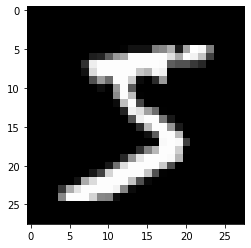

In [204]:
plt.imshow(train_x[0,:].view(28,28), cmap= "gray")

Wir haben bis jetzt nur ein Bild das richtige Format gebracht, um alle Bilder auf einmal in dem richtigen Format zu bringen, können wir aber auch `.view()` benutzen. Das Tensor oben hatte den Format `(Höhe,Breite)`. Damit wir alle Bilder konvertieren können, müssen wir denn `tensor` um eine weitere Dimension erweitern.  Wir wollen einen `tensor` mit den Dimensionen `(Anzahl Bilder, Höhe, Breite)`.

Allerdings würde hier PyTorch einen Strich durch die Rechnung machen. PyTorch kann sowohl mit Schwarz-Weiß Bildern, als auch mit farbigen Bildern arbeiten. In PyTorch werden farbige Bilder über drei Matrizen dargestellt. Eine für Rot, eine für Grün und eine für Blau. Diese werden auch als Channel bezeichnet. Also ein farbiges Bild hat 3 Channel, ein s/w Bild hat aber nur einen.
Ein farbiges Bild würde in PyTorch die Dimensionen `(3, Höhe, Breite)` haben. Deswegen geht PyTorch davon aus, dass alle Bilder aus drei Dimensionen besteht. Für eine Schwarz/Weiß Bild brauchen wir deshalb auch eine weitere Dimension. Die dritte Dimension hat aber nur die Größe eins, da wir nur einen Channel haben.
![](https://miro.medium.com/max/700/1*icINeO4H7UKe3NlU1fXqlA.jpeg)

<center><h7>Source: Mathanraj Sharma, 2019 </h7></center>

Deshalb stellen wir ein s/w Bild wie folgt dar: `(1, Höhe, Breite)`. Daraus folgt, dass alle Bilder vom MNIST Datensatz diesem Format entsprechen müssen: `(Anzahl Bilder, 1, Höhe, Breite)`



Konvertieren Sie `train_x` in dieses Format.

In [6]:
train_x = train_x.view(_____,1,____,____)
train_x.shape

torch.Size([60000, 1, 28, 28])

<details>
<summary><b>Lösung:</b></summary>
    
```python 
train_x = train_x.view(60000,1,28,28)
```
</details>

Sie haben jetzt alle Bilder in das Format `(1,28,28)` konvertiert.
Sie können jetzt immer noch die Bilder mit `plt.imshow` anzeigen lassen.

Beachten Sie, wie jetzt der Tensor indiziert ist. `[0,0,:,:]`. Wir wählen das erste Bild aus, und auch den ersten und einzigen Channel. Wir wählen natürlich die gesamte Höhe und Breite aus, um das Bild komplett darzustellen.

In [203]:
plt.imshow(train_x[0,0,:,:], cmap= "gray")

IndexError: too many indices for tensor of dimension 2

Wie letzte Woche können Sie sich auch diesmal einen `DataLoader` benutzen. Dafür müssen wir erst ein TensorDataset erstellen. Mit `next(iter())` können wir uns den ersten Batch des Dataloaders ausgeben lassen.

In [24]:
torch_train = data.TensorDataset(_____, ____)
train_loader = data.DataLoader(______, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
print(batch_x.shape, batch_y.shape)

NameError: name '_____' is not defined

<details>
<summary><b>Lösung:</b></summary>
    
```python 
torch_train = data.TensorDataset(train_x,train_y)
train_loader = data.DataLoader(torch_train, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
print(batch_x.shape, batch_y.shape)
```
</details>

In [205]:
train_x = train_x.view(60000,1,28,28)

torch_train = data.TensorDataset(train_x,train_y)
train_loader = data.DataLoader(torch_train, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
batch_x.dtype

torch.float32

Wie Sie sehen können, hat der `batch_x` die Dimensionen `[32, 1, 28, 28]`. Also `32` Bilder, die Größe unseres Batches, `1`Channel, `28` Pixel in der Höhe und `28` in der Breite.

## CNNs in PyTorch erstellen.

Wir haben soweit unsere Daten im richtigen Format, jetzt beschäftigen wir uns mit dem erstellen von `CNN` in PyTorch. Sowie es `linear` layers in PyTorch gibt, gibt es auch Convolutional Layers im `nn` Modul.

`nn.Conv2d()` ist so eine Layer. Bevor wir Sie benutzen, besprechen wir kurz die wichitgsten Parameter.

- `in_channels` Die Anzahl der Channels die das Bild vor Der Convolution hat 
- `out_channels` Wie viel Channels soll, das Bild nach der Convolution haben.
- `kernel_size` Wie groß ist der Kenel, also die Höhe/Breite in Pixeln


In [16]:
conv1 = conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

In [18]:
out = conv1(batch_x)
out.shape

torch.Size([32, 3, 26, 26])

Sie sehen, der Batch hat sich in der Größe verändert. Zunächst haben wir immer noch `32` Bilder, allerdings wie spezifiziert, haben wir jetzt `3` Channel. Auch die Höhe und Breite unseres Bildes hat sich verändert, insgesamt haben wir jeweils 2 Pixel pro Dimension verloren. Das liegt daran, wie Convolutions funktionieren.

![](https://miro.medium.com/max/700/1*L4T6IXRalWoseBncjRr4wQ@2x.gif)
<center><h7>Source: Arden Dertat, 2017 </h7></center>

Hier sehen an einem Beispiel warum bei einer Kernel Size von 3 unser Output Bild um zwei Pixel kleiner wird. Links ist das Inputfile und rechts der Output. Da wir den Kernel nicht über den Rand des Bildes schieben können, "verlieren" wir den äußern Rand des Bildes

Um zu verhindern, dass diese Information verloren geht, können wir das Bild *padden*. Dadurch vergrößern wir das Bild, zum Beispiel mit Pixel, die den Wert Null haben.
![](https://miro.medium.com/max/700/1*W2D564Gkad9lj3_6t9I2PA@2x.gif)
<center><h7>Source: Arden Dertat, 2017 </h7></center>

Durch das Padding, kann der Kernel einmal über das ganze Bild geschoben werden.
Wir können die Breite des Paddings auch als Parameter in `Conv2d` mitgeben.

In [213]:
conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding =1)
out = conv1(batch_x)
out.shape

torch.Size([32, 3, 28, 28])

Durch das Padding schrumpft nun das Bild nicht in der Breite. Dadurch, dass wir jetzt `3` Channel haben, können wir dieses immer noch mit `plt.imshow` uns zeigen lassen.  Hierbei müssen wir den ein Bild aus dem Batch auswählen und mit dem Befehl `detach()` die Gradienten, die durch `autograd` gespeichert werden, entfernen.

*Ein solches Bild, kann man nur als Beispiel benutzen um die Transformation zu verdeutlichen. Die tatsächlichen Farben und Intensitäten sind hier aber irrelevant, da Sie von dem Netzwerk arbiträr gewählt sind. Zum Beispiel, gibt die Reihenfolge der Channels an, welcher Channel für welche Farbe zuständig ist. Ein Convolution ist sich natürlich nicht bewusst, dass es so eine Ordnung in den Channels gibt.*

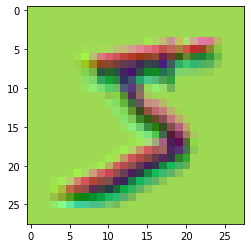

In [214]:
plt.imshow(min_max(out.detach().numpy()[0].transpose((1, 2, 0))))


Sie können immer noch eine 5 erkennen, allerdings diesmal in Farbe. Wie oben schon beschrieben, eigenen sich die Farben nicht zum Interpretieren. Es soll lediglich die Diversifizierung des Inputs darstellen. Der weitere neue Layer die Sie heute benutzen werden ist `nn.MaxPool2d()`. 

Dieses Layer ist einen **Pooling** Layer.


![](https://miro.medium.com/max/700/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png)
<center><h7>Source: Arden Dertat, 2017 </h7></center>

Pooling Layer führen zu eine Reduzierung der Bildgröße. Dadurch brauchen weniger Parameter (Weights), was dazu führt, das unsere Netzwerke schneller trainieren. Wenn Sie ein Bild (größer als 28 x 28 Pixel)anschauen, dann sehen nicht jeden einzelnen Pixel, sondern Pixel in einer gewissen Proximität werden schmelzen zusammen. Pooling funktioniert ähnlich. Hier werden mehrer Pixel mit Hifle des domminantesten Wertes zusammen gefasst.
Weniger Parameter, bedeuete auch eine geringere Chance zu overfitten. 

Die meist benutzte Pooling Layer ist die Max Pooling Layer. Hierbei wird der größte Wert im Kernel, als neuer Wert für den Output gewählt. Es gibt natürlich eine Vielzahl von anderen [Pooling](https://pytorch.org/docs/stable/nn.html#pooling-layers) Layers.

Neben der Kernel Size, die Größe der des Quadrates das gepoolt werden soll, geben wir diesmal auch den `stride` an. Der Stride gibt an, um wieviele Pixel wir den Kernel verschieben. 

![](https://www.oreilly.com/library/view/machine-learning-for/9781786469878/assets/09ad7edc-334f-4c54-944b-af21139b0587.png)
<center><h7>Source: Rodolfo Bonnin - Machine Learning for Developers </h7></center>

In [189]:
pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)


Sie können jetzt den Output der 2DConv (`out`) als Input für die Pooling Layer benutzen.  

In [190]:
out2 = pool1(____)
out2.shape

NameError: name '____' is not defined

<details>
<summary><b>Lösung:</b></summary>
    
```python 
out2 = pool1(out)
```
</details>

Da sich nichts an der Anzahl der Channels geändert hat, können wir dieses Bild immernoch visualsieren.
Es ist zu erkennen, dass sich das Bild verkleinert hat, dennoch könnnen wir noch eine 5 erkennen.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


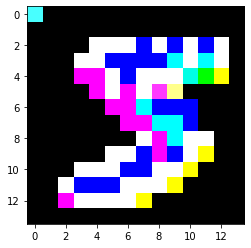

In [191]:
plt.imshow(min_max(out2.detach().numpy()[0].transpose((1, 2, 0)))

Mit `nn.Sequential` können Sie auch wieder mehrere Layers hintereinander schalten. Wichitg, wir brauchen auch wieder eine nicht-lineare Aktivierungsfunktion, diese wird normalerweise nach dem Convolution eingefügt.

Füllen Sie den Code aus:

In [192]:
cnn = nn.Sequential(nn.Conv2d(_,3,3,1),
                   nn.ReLU(),
                   nn.MaxPool2d(2,2),
                   nn.Conv2d(__,6,3,1),
                   nn.______,
                   nn.MaxPool2d(2,2))

TypeError: unsupported operand type(s) for %: 'AxesImage' and 'int'

<details>
<summary><b>Lösung:</b></summary>
    
```python 
cnn = nn.Sequential(nn.Conv2d(1,3,3,1),
                   nn.ReLU(),
                   nn.MaxPool2d(2,2),
                   nn.Conv2d(3,6,3,1),
                   nn.ReLU(),
                   nn.MaxPool2d(2,2))
```
</details>

Jetzt können wir den Batch `batch_x` einmal durch das Netzwerk führen. 

Dieser Output eignet sich aber noch nicht um Vorhersagen zumachen. Um diese zu machen müssen wir die Bilder wieder ein traditionales Neuronales Netzwerk benutzen. Doch diese akzeptieren nur Input in Form eines Vektors. Deshlab konvertieren wir jedes Bild zurück in einen Vektor. 

Also unser Tensor hat die `shape` `[32, 6, 5, 5]` und soll zu einem Tensor `[32, 6 x 5 x 5]` = `[32, 150]`.

Dafür können wir die "Layer" `nn.Flatten(starting_dim)` benutzen. Hierbei müssen wir nur den Parameter `starting_dim` festlegen. Dieser bestimmt ab welche Dimenion wir beginnen die Dimensionen zusamme zu führen. Da wir die für jedes Bild einen eigenen Vektor wollen, benutzen eine `starting_dim = 1`. Mit cnn.add_module(), können wir noch extra Layers zu unserem Modul hinzufügen.


In [194]:
cnn.add_module("flatten",nn.Flatten(1))

In [195]:
cnn(batch_x).shape

torch.Size([32, 150])

In [196]:
cnn.add_module("fc", nn.Linear(150,10))

In [197]:
loss_funktion = nn.CrossEntropyLoss()
updaten =  torch.optim.SGD(cnn.parameters(), lr =0.001)

In [227]:
EPOCHS = 10
for i in range(EPOCHS):
    loss_list = [] # diese Liste speichter den Loss jedes Minibatches
                   # damit können wir am Ende den Durschnittslost innerhalb des Epochs berechnen
    for minibatch in train_loader: # for-loop geht durch alle minibatches
        images, labels = minibatch # minibatch wird in Bilder und Labels geteilt

        updaten.zero_grad()
        output = cnn(images) # Forward Propagation
        loss   = loss_funktion(output, labels)
        loss.backward()
        loss_list.append(loss.item())
        updaten.step()
        
    output = cnn(train_x)
    train_acc=((output.max(dim=1)[1]==train_y).sum()/float(output.shape[0])).item()
    print(
        "Training Loss: %.2f Training Accuracy: %.2f"
        % (np.mean(loss_list), train_acc)
    )

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [3, 1, 3, 3], but got 2-dimensional input of size [60000, 784] instead

In [224]:
test_data = np.genfromtxt('../data/mnist/mnist_test.csv', delimiter=',', skip_header =False)

test_x = torch.tensor(min_max(test_data[:,1:]), dtype=torch.float32)
test_y = torch.tensor(test_data[:,0], dtype=torch.long)
test_x = test_x.reshape(test_x.shape[0],1,28,28)
print(test_x.shape, test_y.shape)

torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [226]:
output = cnn(test_x)
acc=((output.max(dim=1)[1]==test_y).sum()/float(output.shape[0])).item()
acc

0.9383999705314636